In [ ]:
import sys
sys.path.append("..")
from BacktestApp import BacktestApp
from utils import vwap, is_within_specific_minutes_of_close

import pandas as pd
pd.set_option('display.max_rows', 390)  # 允许最多显示 100 行

def vwap_rolling(close, volume, window=10):
    price_volume = close * volume
    # 使用滚动窗口计算窗口内的累加和
    rolling_price_volume = price_volume.rolling(window=window).sum()
    rolling_volume = volume.rolling(window=window).sum()
    
    # 计算滚动VWAP
    return rolling_price_volume / rolling_volume

def fill_small_gaps_vectorized(df, col='sideways_market', gap_threshold=5):
    # 拷贝 DataFrame，避免修改原数据
    df = df.copy()
    
    # 生成组号，每当值发生变化时，组号自增
    df['grp'] = (df[col] != df[col].shift()).cumsum()
    
    # 按组汇总：每个组的值和组内元素个数
    group_summary = df.groupby('grp')[col].agg(['first','size'])
    # 添加前一组和后一组的值（利用 shift）
    group_summary['prev'] = group_summary['first'].shift(1)
    group_summary['next'] = group_summary['first'].shift(-1)
    
    # 找出满足条件的 False 组：
    # 当前组值为 False，组长度小于 gap_threshold，
    # 且前一组和后一组的值均为 True
    fill_groups = group_summary[
        (group_summary['first'] == False) &
        (group_summary['size'] < gap_threshold) &
        (group_summary['prev'] == True) &
        (group_summary['next'] == True)
    ].index
    
    # 将这些组对应的区域标记为 True
    df.loc[df['grp'].isin(fill_groups), col] = True
    
    # 删除辅助的组号列
    df.drop(columns=['grp'], inplace=True)
    return df

def remove_small_true_intervals(df, col='sideways_market', min_length=5):
    """
    对连续为 True 的区域，如果长度小于 min_length，则将这些区域全部置为 False。

    :param df: DataFrame，包含布尔列
    :param col: 布尔列名称，默认为 'sideways_market'
    :param min_length: True 区间最小长度，小于此值的区间全部设置为 False
    :return: 修改后的 DataFrame
    """
    df = df.copy()
    # 生成组号：当列值发生变化时，组号递增
    df['grp'] = (df[col] != df[col].shift()).cumsum()
    
    # 汇总各组：记录组内的值和组内的长度
    group_summary = df.groupby('grp')[col].agg(['first', 'size'])
    
    # 筛选出连续 True 但长度小于 min_length 的组
    small_true_groups = group_summary[
        (group_summary['first'] == True) & (group_summary['size'] < min_length)
    ].index
    
    # 将这些组对应的区域全部设置为 False
    df.loc[df['grp'].isin(small_true_groups), col] = False
    
    # 删除辅助的分组列
    df.drop(columns=['grp'], inplace=True)
    return df

class Trend:
    def __init__(self, contract, pm):
        self.contract = contract
        self.pm = pm
        
        self.vwap_slope_threhold = 0.07
        self.close_pct_change_threhold = 0.07
        
    def calculate_open_amount(self, bars):
        if self.pm.net_liquidation is None or self.pm.available_funds is None:
            print("PositionManager.calculate_open_amount net_liquidation or available_funds is None")
            return 0
        
        target_market_value = self.pm.net_liquidation * 0.1
        if target_market_value > self.pm.available_funds: return 0
        
        open_amount = target_market_value / bars.iloc[-1]['close']
        open_amount = round(open_amount / 10) * 10  # 调整为 10 的倍数
        return int(open_amount)

    def find_position(self):
        is_match = lambda item: (
            item["contract"] == self.contract and
            item["strategy"] == "Trend"
        )
        return self.pm.find_position(is_match)
    
    def setParams(self, bars):
        # bars["close_rolling_10"] = bars["close"].rolling(window=10).sum()
        # bars["volume_rolling_10"] = bars["volume"].rolling(window=10).sum()
        # bars["vwap"] = bars["close_rolling_10"] / bars["volume_rolling_10"]
        bars["vwap"] = vwap(bars["close"], bars["volume"])
        # 计算滚动窗口（60）内的 VWAP
        rolling_vwap = vwap_rolling(bars["close"], bars["volume"], 90)

        # 用滚动 VWAP 替换从第90行开始的值
        bars.loc[rolling_vwap.index[90:], "vwap"] = rolling_vwap.iloc[90:]
        # bars["vwap"] = vwap(bars["close"], bars["volume"])
        bars['ema10'] = bars['close'].ewm(span=10, adjust=False).mean()

        bars["close_pct_change"] = bars["close"].pct_change() * 100
        bars["vwap_pct_change"] = bars["vwap"].pct_change() * 100
        bars["vwap_pct_change_std"] = bars['vwap_pct_change'].rolling(window=10).std()
        
        vwap_slop_threshold = 8 / 1000  # 需要调整阈值
        vwap_pct_change_std_threshold = 7 / 1000  # 需要调整阈值
        
        bars["vwap_slope"] = bars["vwap_pct_change"]
        bars['sideways_market'] = (bars['vwap_slope'].abs() < vwap_slop_threshold)# | (bars["vwap_pct_change_std"] < vwap_pct_change_std_threshold)
        # bars = fill_small_gaps_vectorized(bars, 'sideways_market', gap_threshold=5)
        # bars = remove_small_true_intervals(bars, col='sideways_market', min_length=5)
        return bars
    
    def get_open_signal(self, bars):
        single = None
        begin_idx = bars.loc[bars['sideways_market'] == True].index.max()
        if not pd.isna(begin_idx): 
            if begin_idx != len(bars) -1:
                # begin_idx += 1
                begin_idx -= 2
        else: begin_idx = 0
        vwap_pct_change = (bars.iloc[-1]["vwap"] - bars.iloc[begin_idx]["vwap"]) / bars.iloc[begin_idx]["vwap"]
        close_pct_change = (bars.iloc[-1]["close"] - bars.iloc[begin_idx]["close"]) / bars.iloc[begin_idx]["close"]
        ratio = close_pct_change / vwap_pct_change if vwap_pct_change != 0 else 0
        if (bars.iloc[-1]["vwap_slope"] >= self.vwap_slope_threhold) and (bars.iloc[-1]["close_pct_change"] >= self.close_pct_change_threhold):
            single = "做多"
        if (bars.iloc[-1]["vwap_slope"] <= -1 * self.vwap_slope_threhold) and (bars.iloc[-1]["close_pct_change"] <= -1 * self.close_pct_change_threhold):
            single = "做空"
        if ratio < 0.5: single = None
        return single
                
    def update(self, bars):
        bars = self.setParams(bars)
        if len(bars) < 2: return
        open_singal = self.get_open_signal(bars)
        position = self.find_position()
        # if bars.iloc[-2]["vwap_pct_change"] * bars.iloc[-1]["vwap_pct_change"] < 0:
        if open_singal:
            direction = bars.iloc[-1]["vwap_pct_change"] / abs(bars.iloc[-1]["vwap_pct_change"])
            amount = self.calculate_open_amount(bars) * direction
            if not position:
                if not is_within_specific_minutes_of_close(bars, 30):
                    self.pm.open_position(self.contract, "Trend", amount, bars)
            else:
                if position["amount"] * bars.iloc[-1]["vwap_pct_change"] < 0:
                    self.pm.close_position(position, bars)
                    if not is_within_specific_minutes_of_close(bars, 30):
                        self.pm.open_position(self.contract, "Trend", amount, bars)
        position = self.find_position()
        if position and is_within_specific_minutes_of_close(bars, 10):
            self.pm.close_position(position, bars)
        
class TrendBacktestApp(BacktestApp):
    def __init__(self, config_file="config.yml", **kwargs):
        super().__init__(config_file, **kwargs)
        self.trend = { contract.symbol: Trend(contract, self.pm) for contract in self.contracts }
        
    def on_bar_update(self, contract, bars, has_new_bar):
        bars = bars.copy()
        self.trend[contract.symbol].update(bars)

try:
    ba = TrendBacktestApp(config_file="../config_backtest.yml", clientId=20, debug=True)
    end_date = "2024-07-07"
    duration_str = "20 D"
    ba.minutes_backtest(end_date, duration_str)
finally:
    ba.ib.disconnect()

做多 2024-06-06 09:32:00-04:00 False
【2024-06-06 09:32:00-04:00】【Trend】开仓: NVDA, 价格: 124.38, 数量：800.0, 浮动盈亏：None
【2024-06-06 09:48:00-04:00】【Trend】平仓: NVDA, 价格: 122.0, 数量：-800.0, 浮动盈亏：-1903.9999999999964
做空 2024-06-06 09:48:00-04:00 -0.1364793350498772 False
【2024-06-06 09:48:00-04:00】【Trend】开仓: NVDA, 价格: 122.0, 数量：-820.0, 浮动盈亏：None
【2024-06-06 15:50:00-04:00】【Trend】平仓: NVDA, 价格: 120.9, 数量：820.0, 浮动盈亏：901.9999999999953
做多 2024-06-07 09:31:00-04:00 False
【2024-06-07 09:31:00-04:00】【Trend】开仓: NVDA, 价格: 119.14, 数量：840.0, 浮动盈亏：None
【2024-06-07 15:50:00-04:00】【Trend】平仓: NVDA, 价格: 120.89, 数量：-840.0, 浮动盈亏：1470.0
做多 2024-06-10 09:32:00-04:00 False
【2024-06-10 09:32:00-04:00】【Trend】开仓: NVDA, 价格: 121.04, 数量：830.0, 浮动盈亏：None
【2024-06-10 09:44:00-04:00】【Trend】平仓: NVDA, 价格: 119.33, 数量：-830.0, 浮动盈亏：-1419.3000000000065
做空 2024-06-10 09:44:00-04:00 -0.07168075855710221 False
【2024-06-10 09:44:00-04:00】【Trend】开仓: NVDA, 价格: 119.33, 数量：-840.0, 浮动盈亏：None
【2024-06-10 15:50:00-04:00】【Trend】平仓: NVDA, 价格: 121.7

In [79]:
ba.statistic()

{'cumulative_pnl': np.float64(-6496.921983999782),
 'max_drawdown': np.float64(0.010852201016162712),
 'sharpe_ratio': np.float64(-1.613556842374652),
 'volatility': np.float64(0.051202759344543464),
 'daily_return': np.float64(-0.00018896255035258234),
 'commission': np.float64(479.13321600000006)}

In [80]:
from plot import prepare_trade_history, generate_macd_panel, generate_vwap_panel, mark_bs_point, modify_macd_range
import matplotlib.pyplot as plt
import mplfinance as mpf

def plot_debug_structure(df, trade_history):
    """
    Debug structure
    :params
    df: quote of stock
    trade_history: trade signals
    """
    df = prepare_trade_history(df, trade_history)
    df, macd_panel = generate_macd_panel(df)
    df, vwap_panel = generate_vwap_panel(df)
    
    ema10 = [
        mpf.make_addplot(df['ema10'], color='green', linestyle='solid', width=1, label='EMA 10')
    ]

    # 找到连续震荡的时间段
    sideways_periods = []
    start = None

    for i in range(len(df)):
        if df.iloc[i]['sideways_market']:
            if start is None:
                start = df.index[i]  # 记录震荡市场的起点
        else:
            if start is not None:
                sideways_periods.append((start, df.index[i]))  # 记录起止时间
                start = None

    if start is not None:
        sideways_periods.append((start, df.index[-1]))

    # 定义子图
    panels = macd_panel + vwap_panel + ema10
    
    fig, axes = mpf.plot(df, type='line', ylabel='Price', 
            addplot=panels,
            panel_ratios=(3, 1),  # 设置主图和副图的比例
            volume=False,         # 不显示成交量
            figsize=(10, 6),
            returnfig=True)       # 返回figure和axes对象

    # 标记买卖点
    mark_bs_point(df, axes)

    # 修正 MACD 轴范围
    modify_macd_range(df, axes)

    # **在主图上标注震荡市场**
    ax_main = axes[0]
    # ax_main.set_ylim([97, 120])

    for start, end in sideways_periods:
        start_idx = df.index.get_loc(start)
        end_idx = df.index.get_loc(end)
        ax_main.axvspan(start_idx, end_idx, color='gray', alpha=0.3)  # 震荡区域填充背景色


    # 显示图像
    plt.show()


In [104]:
idx = 0

8 2024-06-18 999951.445976


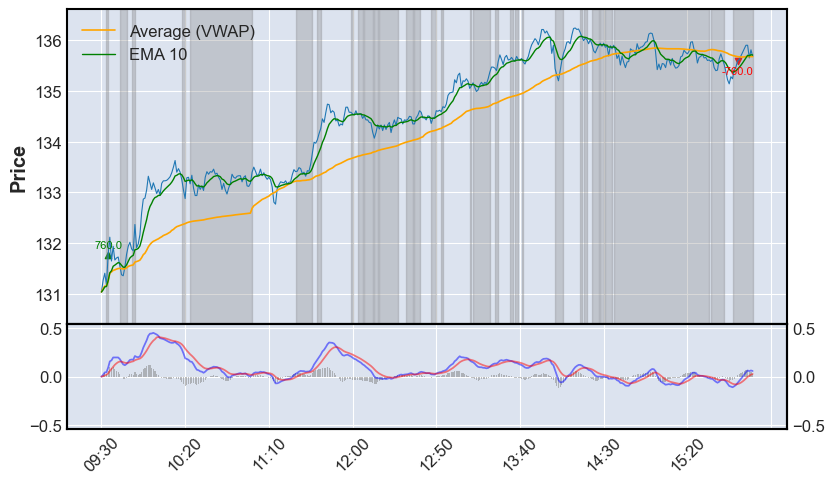

In [112]:
while True:
    history = pd.DataFrame(ba.pm.trade_log)
    daily = ba.get_historical_data(ba.contracts[0], end_date, duration_str, '1 day')
    date = daily.iloc[idx]['date']
    print(idx, date, ba.daily_net_liquidation[idx]["net_liquidation"])
    specific_day_history = history[history['date'].dt.date == date].to_dict(orient='records')
    idx += 1
    if len(specific_day_history) != 0:
        df = ba.get_historical_data(ba.contracts[0], date)
        st = Trend(ba.contracts[0], ba.pm)
        df = st.setParams(df)
        # df = df.iloc[:120]
        plot_debug_structure(df.set_index("date", drop=True), specific_day_history)
        break

In [ ]:
df[['date', 'volume', 'close', 'vwap', 'vwap_slope', 'vwap_pct_change', 'vwap_pct_change_std', 'sideways_market']]
# df.loc[30:90]["vwap_slope"].min()

In [ ]:
pd.DataFrame(ba.pm.trade_log)